In [2]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree

# Load the datasets
listings_transport_df = pd.read_csv('listings_with_transport.csv')
monuments_df = pd.read_csv('monuments.csv')

# Function to find nearest monuments
def find_nearest_monuments(listings, monuments, k=5):
    monuments_tree = cKDTree(monuments[['longitude', 'latitude']])
    distances, indices = monuments_tree.query(listings[['longitude', 'latitude']], k=k)
    
    for i in range(k):
        listings[f'nearest_monument_{i+1}'] = monuments.iloc[indices[:, i]]['nomcom'].values
        listings[f'distance_to_monument_{i+1}'] = distances[:, i]
    
    return listings

# Find nearest monuments for each listing
combined_df = find_nearest_monuments(listings_transport_df, monuments_df)

# Display the first few rows of the combined dataset
print(combined_df.head())

# Save the combined dataset
combined_df.to_csv('listings_transport_monuments.csv', index=False)

      id                                          name  host_id  host_name  \
0  80260             Nice studio in Jourdain's village   333548  Charlotte   
1   3109                                  zen and calm     3631       Anne   
2  80301                                toits de Paris   433758  Genevieve   
3   5396  Your perfect Paris studio on Île Saint-Louis     7903     Borzou   
4   7397              MARAIS - 2ROOMS APT - 2/4 PEOPLE     2626     Franck   

   host_since host_is_superhost            neighbourhood  latitude  longitude  \
0  2011-01-03                 f                      NaN  48.87131    2.38848   
1  2008-10-14                 f  Neighborhood highlights  48.83191    2.31870   
2  2011-03-10                 t  Neighborhood highlights  48.83918    2.34699   
3  2009-02-14                 f  Neighborhood highlights  48.85247    2.35835   
4  2008-08-30                 t                      NaN  48.85909    2.35315   

                 property_type  ... nearest_

In [8]:
# !pip install folium

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.plugins import MarkerCluster

C:\Users\bbode\AppData\Local\Temp\ipykernel_14308\513399422.py:33: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df, x='longitude', y='latitude', weights='price', cmap='YlOrRd', shade=True)


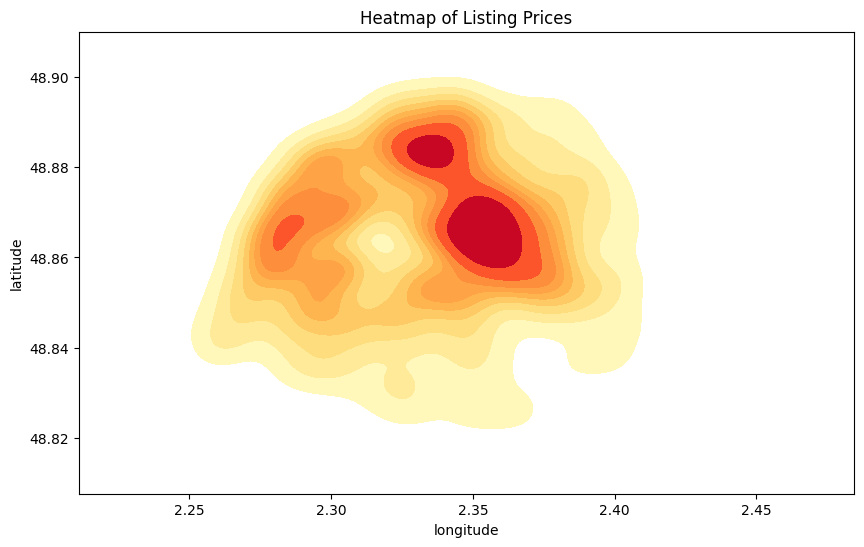

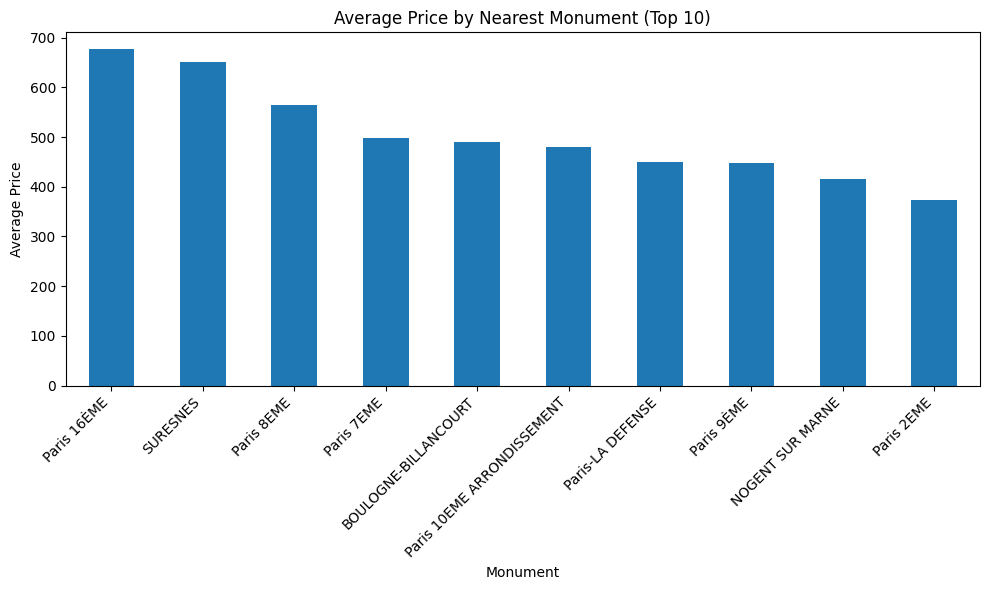

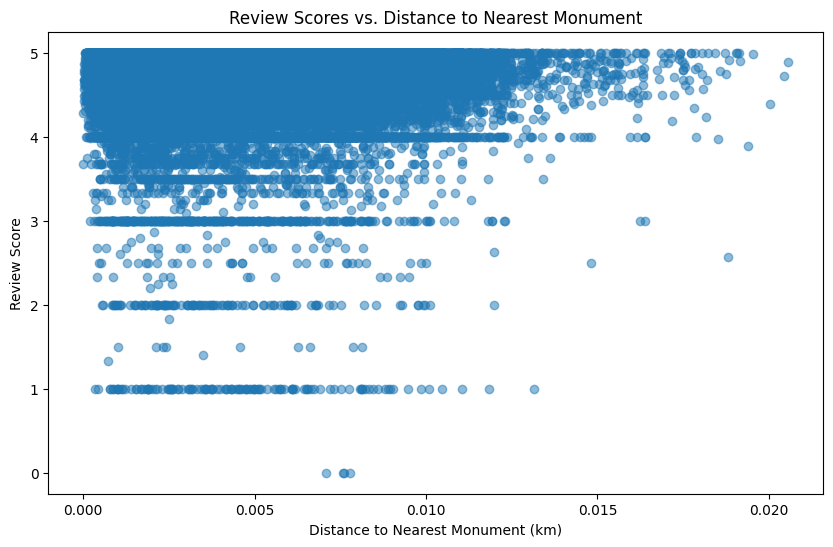

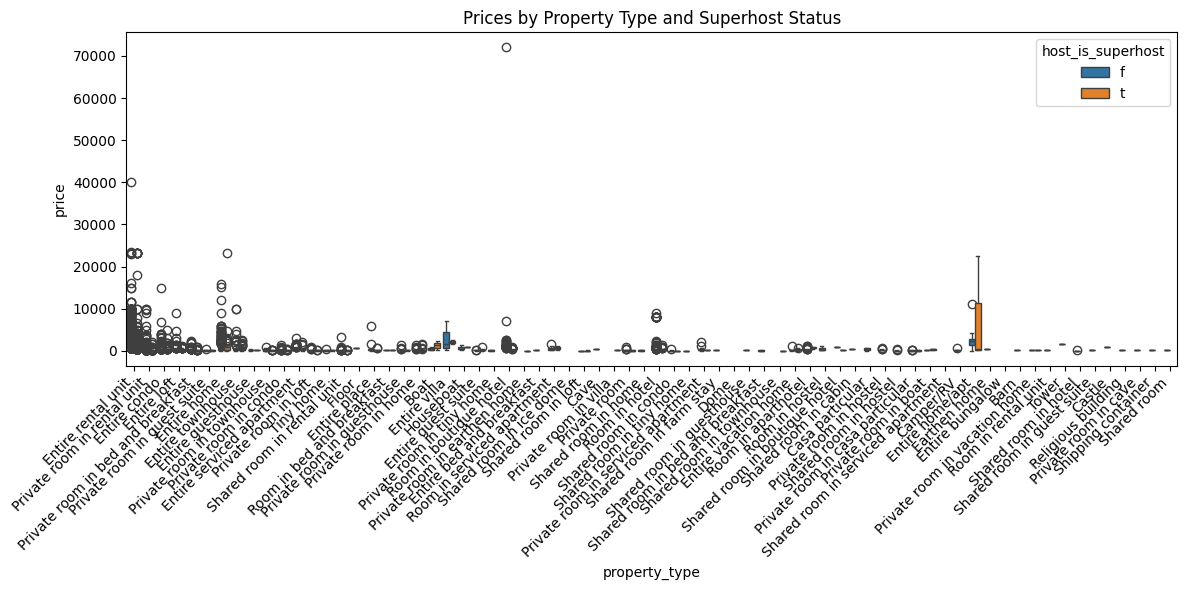

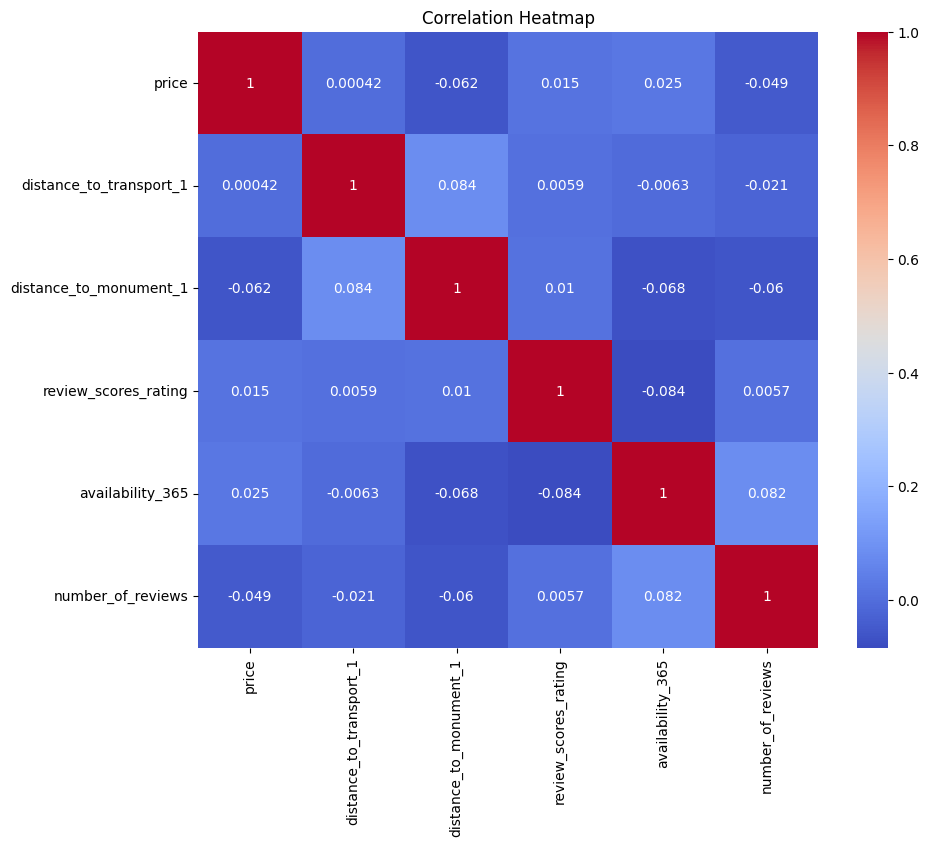

Visualizations have been saved as PNG files and an HTML file.
                                      name  price  review_scores_rating  \
95768   Modern, bright and fully renovated   94.0                   5.0   
58693         Vibrant Parisien appartement   97.0                   5.0   
58679       Studio Paris 16 métro Exelmans   36.0                   5.0   
58666        Pte de Versailles / Parc Expo   79.0                   5.0   
27401  Paris 17- Batignolles-chambre 10 m2   46.0                   5.0   

      nearest_monument_1           nearest_transport_1  
95768              Paris            Kléber - Boissière  
58693        Paris 19EME                      Jourdain  
58679              Paris  Versailles - Chardon Lagache  
58666              PARIS      Vaugirard - Croix-Nivert  
27401              Paris   Pont Cardinet - Batignolles  


In [12]:


# Load the combined data
df = pd.read_csv('listings_transport_monuments.csv')

# 1. Interactive map of listings, transport, and monuments
m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=12)

# Add listings
listings_cluster = MarkerCluster(name="Listings").add_to(m)
for idx, row in df.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=f"Price: {row['price']}, Nearest Monument: {row['nearest_monument_1']}",
        icon=folium.Icon(color='blue', icon='home')
    ).add_to(listings_cluster)

# Add monuments
monuments_cluster = MarkerCluster(name="Monuments").add_to(m)
for idx, row in monuments_df.iterrows():
    folium.Marker(
        [row['latitude'], row['longitude']],
        popup=row['nomcom'],
        icon=folium.Icon(color='red', icon='info-sign')
    ).add_to(monuments_cluster)

# Add layer control
folium.LayerControl().add_to(m)

# Save the map
m.save('paris_map.html')

# 2. Heatmap of listing prices
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='longitude', y='latitude', weights='price', cmap='YlOrRd', shade=True)
plt.title('Heatmap of Listing Prices')
plt.show()

# 3. Bar plot of average price by nearest monument
top_10_monuments = df.groupby('nearest_monument_1')['price'].mean().nlargest(10)
plt.figure(figsize=(10, 6))
top_10_monuments.plot(kind='bar')
plt.title('Average Price by Nearest Monument (Top 10)')
plt.xlabel('Monument')
plt.ylabel('Average Price')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 4. Scatter plot of review scores vs. distance to nearest monument
plt.figure(figsize=(10, 6))
plt.scatter(df['distance_to_monument_1'], df['review_scores_rating'], alpha=0.5)
plt.title('Review Scores vs. Distance to Nearest Monument')
plt.xlabel('Distance to Nearest Monument (km)')
plt.ylabel('Review Score')
plt.show()

# 5. Box plot of prices by property type and superhost status
plt.figure(figsize=(12, 6))
sns.boxplot(x='property_type', y='price', hue='host_is_superhost', data=df)
plt.title('Prices by Property Type and Superhost Status')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 6. Correlation heatmap
features = ['price', 'distance_to_transport_1', 'distance_to_monument_1', 'review_scores_rating', 'availability_365', 'number_of_reviews']
correlation_matrix = df[features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

print("Visualizations have been saved as PNG files and an HTML file.")

# 7. Recommendation function
def recommend_listings(df, budget, min_rating, max_distance_to_monument, max_distance_to_transport):
    recommendations = df[
        (df['price'] <= budget) &
        (df['review_scores_rating'] >= min_rating) &
        (df['distance_to_monument_1'] <= max_distance_to_monument) &
        (df['distance_to_transport_1'] <= max_distance_to_transport)
    ].sort_values('review_scores_rating', ascending=False)
    
    return recommendations[['name', 'price', 'review_scores_rating', 'nearest_monument_1', 'nearest_transport_1']]

# Example usage
print(recommend_listings(df, budget=100, min_rating=4.5, max_distance_to_monument=2, max_distance_to_transport=0.5).head())